# Sign Language Recognition

The original MNIST image dataset of handwritten digits is a popular benchmark for image-based machine learning methods but researchers have renewed efforts to update it and develop drop-in replacements that are more challenging for computer vision and original for real-world applications. As noted in one recent replacement called the Fashion-MNIST dataset, the Zalando researchers quoted the startling claim that "Most pairs of MNIST digits (784 total pixels per sample) can be distinguished pretty well by just one pixel". To stimulate the community to develop more drop-in replacements, the Sign Language MNIST is presented here and follows the same CSV format with labels and pixel values in single rows. The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z which require motion).

The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. The original hand gesture image data represented multiple users repeating the gesture against different backgrounds. The Sign Language MNIST data came from greatly extending the small number (1704) of the color images included as not cropped around the hand region of interest. To create new data, an image pipeline was used based on ImageMagick and included cropping to hands-only, gray-scaling, resizing, and then creating at least 50+ variations to enlarge the quantity. The modification and expansion strategy was filters ('Mitchell', 'Robidoux', 'Catrom', 'Spline', 'Hermite'), along with 5% random pixelation, +/- 15% brightness/contrast, and finally 3 degrees rotation. Because of the tiny size of the images, these modifications effectively alter the resolution and class separation in interesting, controllable ways.

This dataset was inspired by the Fashion-MNIST 2 and the machine learning pipeline for gestures by Sreehari 4.

A robust visual recognition algorithm could provide not only new benchmarks that challenge modern machine learning methods such as Convolutional Neural Nets but also could pragmatically help the deaf and hard-of-hearing better communicate using computer vision applications. The National Institute on Deafness and other Communications Disorders (NIDCD) indicates that the 200-year-old American Sign Language is a complete, complex language (of which letter gestures are only part) but is the primary language for many deaf North Americans. ASL is the leading minority language in the U.S. after the "big four": Spanish, Italian, German, and French. One could implement computer vision in an inexpensive board computer like Raspberry Pi with OpenCV, and some Text-to-Speech to enabling improved and automated translation applications.

Source: https://www.kaggle.com/datasets/datamunge/sign-language-mnist?resource=download

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import fashion_mnist
from keras import Sequential
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras import regularizers
from tensorflow.compat.v1.losses import sparse_softmax_cross_entropy

from sklearn.preprocessing import LabelEncoder

from livelossplot import PlotLossesKeras

# Import the training and test datasets

In [2]:
df_train = pd.read_csv("sign_mnist_train.csv")
df_test = pd.read_csv("sign_mnist_test.csv")
nr_train_events = df_train.shape[0]
nr_test_events = df_test.shape[0]

In [3]:
X_train = df_train.iloc[:,1:].to_numpy()
y_train = df_train.iloc[:,0:1].to_numpy().flatten()
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
X_test = df_test.iloc[:,1:].to_numpy()
y_test = df_test.iloc[:,0:1].to_numpy().flatten()

# Encode label

In [4]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [5]:
print("Train-set data shape = ", X_train.shape)
print("Train-set labels shape = ", y_train.shape)

print("Test-set data shape = ", X_test.shape)
print("Test-set data shape = ", y_test.shape)

print("Show Classes = ", np.unique(y_test))
print("Show Nr. of classes = ", len(np.unique(y_test)))

Train-set data shape =  (27455, 784)
Train-set labels shape =  (27455,)
Test-set data shape =  (7172, 784)
Test-set data shape =  (7172,)
Show Classes =  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Show Nr. of classes =  24


# Reshape the data. Images are 28x28 and 1 Channel (gray scale)

In [6]:
X_train = X_train.reshape(nr_train_events, 28, 28, 1)
X_test = X_test.reshape(nr_test_events, 28, 28, 1)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(27455, 28, 28, 1)
(27455,)
(7172, 28, 28, 1)
(7172,)


# Normalize the data between 0 and 1 (colors are coded from 0 to 255 so just divide by 255)

In [8]:
X_train = X_train/255
X_test = X_test/255

# Display a random training sample from each class

Nr Classes


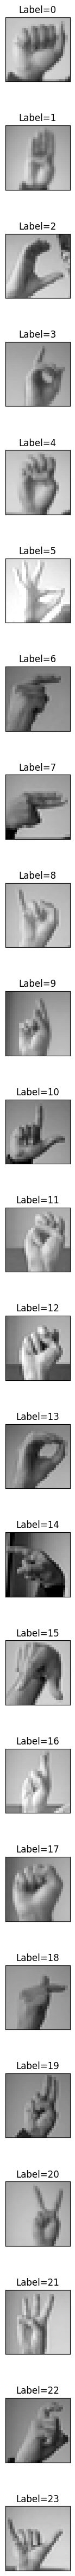

In [9]:
classes_ids = np.unique(y_train)
nr_classes = len(classes_ids)
print("Nr Classes")
f, axes = plt.subplots(len(classes_ids),1, figsize=(2, nr_classes*2))
f.tight_layout()

for cidx, class_id in enumerate(classes_ids):
    class_samples_idxs = np.argwhere(y_train == class_id).flatten()
    range_sel = np.random.randint(0, len(class_samples_idxs)-1, 1, dtype=int).ravel()
    image_idx = class_samples_idxs[range_sel[0]]
    
    class_label = y_train[image_idx]
    image_obj = X_train[image_idx]

    ax=axes[cidx]
    ax.imshow(image_obj, cmap='gray', vmin=0, vmax=1)
    ax.set_title(f"Label={class_label}")
    ax.set_xticks([])
    ax.set_yticks([])


### Define the CNN Architecture

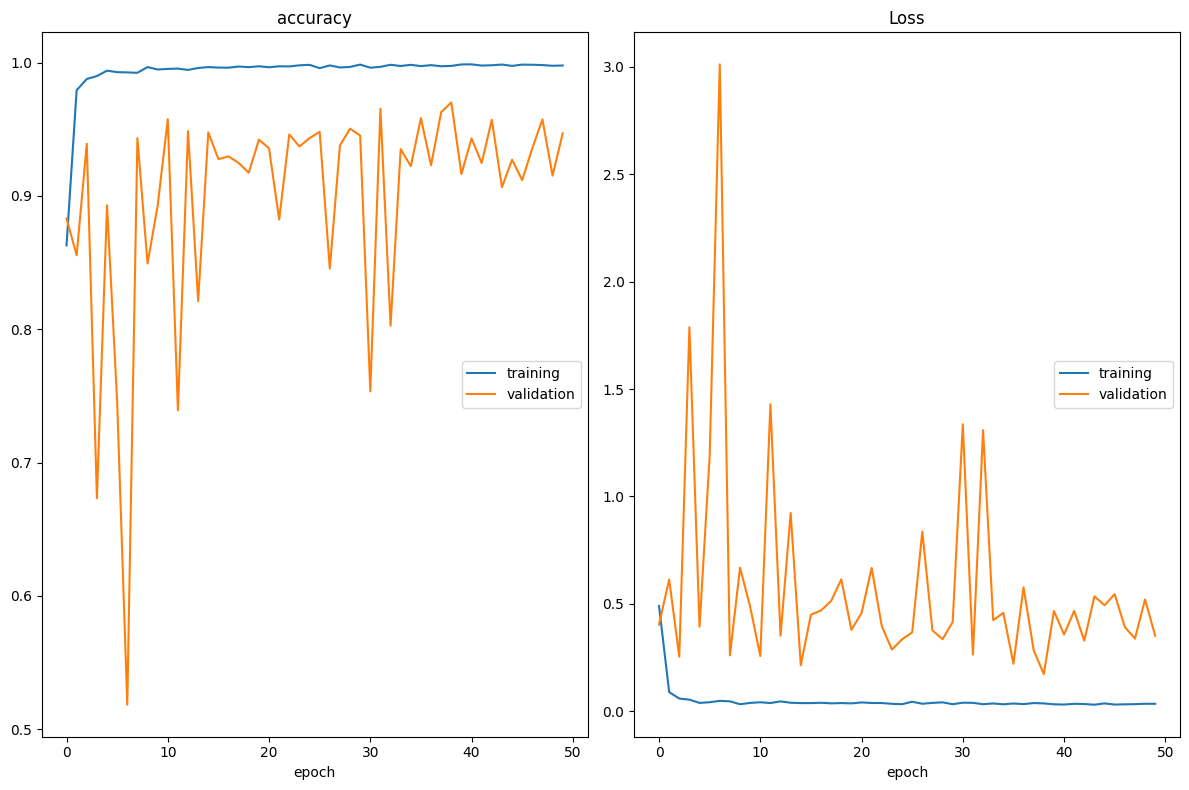

accuracy
	training         	 (min:    0.863, max:    0.999, cur:    0.998)
	validation       	 (min:    0.518, max:    0.970, cur:    0.947)
Loss
	training         	 (min:    0.031, max:    0.490, cur:    0.035)
	validation       	 (min:    0.173, max:    3.011, cur:    0.352)
858/858 [==============================] - 14s 17ms/step - loss: 0.0347 - accuracy: 0.9979 - val_loss: 0.3517 - val_accuracy: 0.9470


In [11]:
model = Sequential()
reg_val = 5e-6

# Convolutional Layer
model.add(Conv2D(64, (3, 3), input_shape=(28, 28, 1), 
            activation='relu',
            kernel_initializer='uniform', 
            kernel_regularizer=regularizers.L2(reg_val), 
            bias_regularizer=regularizers.L2(reg_val), 
            activity_regularizer=regularizers.L2(reg_val)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer
model.add(Conv2D(64, (3, 3), input_shape=(28, 28, 3), activation='relu',
            kernel_initializer='uniform', 
            kernel_regularizer=regularizers.L2(reg_val), 
            bias_regularizer=regularizers.L2(reg_val), 
            activity_regularizer=regularizers.L2(reg_val)))
model.add(BatchNormalization())

# Convolutional Layer
model.add(Conv2D(64, (3, 3), input_shape=(28, 28, 3), activation='relu',
            kernel_initializer='uniform', 
            kernel_regularizer=regularizers.L2(reg_val), 
            bias_regularizer=regularizers.L2(reg_val), 
            activity_regularizer=regularizers.L2(reg_val)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#add flattening layer
model.add(Flatten())

# Full connection
model.add(Dense(units=128, 
                activation='relu', 
                kernel_initializer='uniform', 
                kernel_regularizer=regularizers.L2(reg_val), 
                bias_regularizer=regularizers.L2(reg_val), 
                activity_regularizer=regularizers.L2(reg_val)))
model.add(BatchNormalization())
model.add(Dropout(0.20))

# Hidden layer
model.add(Dense(units=128, 
                activation='relu', 
                kernel_initializer='uniform', 
                kernel_regularizer=regularizers.L2(reg_val), 
                bias_regularizer=regularizers.L2(reg_val), 
                activity_regularizer=regularizers.L2(reg_val)))
model.add(BatchNormalization())
model.add(Dropout(0.20))

# Hidden layer
model.add(Dense(units=128, 
                activation='relu', 
                kernel_initializer='uniform', 
                kernel_regularizer=regularizers.L2(reg_val), 
                bias_regularizer=regularizers.L2(reg_val), 
                activity_regularizer=regularizers.L2(reg_val)))
model.add(BatchNormalization())
model.add(Dropout(0.20))

# Output layer
model.add(Dense(units=nr_classes, activation='softmax'))

# Compile CNN
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the CNN
history = model.fit(X_train, y_train,
            batch_size=32,
            epochs=50,
            validation_data=(X_test, y_test),
            callbacks=[PlotLossesKeras()],
            verbose=1)

# Get the model's performance on the test set

In [12]:
loss, accuracy = model.evaluate(X_test,y_test)
print(f"Loss (sparse_categorical_crossentropy) = {loss}")
print(f"Accuracy = {accuracy}")

225/225 [==============================] - 1s 5ms/step - loss: 0.3517 - accuracy: 0.9470
Loss (sparse_categorical_crossentropy) = 0.3516511023044586
Accuracy = 0.947016179561615
